## Actionable Insights On New Movies
* Anthony Brocco 
* Full Time NYC-DS-080723
* Phase 2  
* Joe Matta

### In this jupyter notebook we explore movie datasets from:

Box Office https://www.boxofficemojo.com/

IMDB https://www.imdb.com/

Rotten Tomatoes https://www.rottentomatoes.com/

TheMovieDB https://www.themoviedb.org/

The Numbers https://www.the-numbers.com/

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

# What genres should we focus on to maximize roi?

In [2]:
#reading in our cleaned budget dataframe
df_budget = pd.read_csv('../zippedData/movie_budget_cleaned.csv', index_col = 0)

In [3]:
#setting a threshold for 'successful' movies
df_successful = df_budget[df_budget['ROI'] > 1]

In [4]:
#reading in our cleaned basics dataframe
df_basics = pd.read_csv('../zippedData/movie_basics_cleaned.csv',index_col = 0)

In [5]:
# Drop 'movie_id' column from df_basics
df_basics = df_basics.drop('movie_id', axis=1)

# Drop 'id' column from df_successful
df_successful = df_successful.drop('id', axis=1)

# Merge the DataFrames using 'movie' column from df_successful and 'primary_title'
merged_df = pd.merge(df_successful, df_basics, left_on='movie', right_on='primary_title', how='inner')

# Create a new DataFrame by combining 'primary_title' and 'original_title'
merged_df['title'] = merged_df['primary_title'].combine_first(merged_df['original_title'])

# Drop 'primary_title' and 'original_title' columns
merged_df = merged_df.drop(['primary_title', 'original_title'], axis=1)

#Create 'successful_movies' dataframe and clean out unneccesary columns or duplicates
successful_movies_df = merged_df.drop(['title', 'start_year'],axis = 1).drop_duplicates(subset = 'movie')

#filtering for movies with budget greater than $20 Mil to make it more relevant to our budget
relevant_movies_df = successful_movies_df[successful_movies_df['production_budget'] > 20000000]

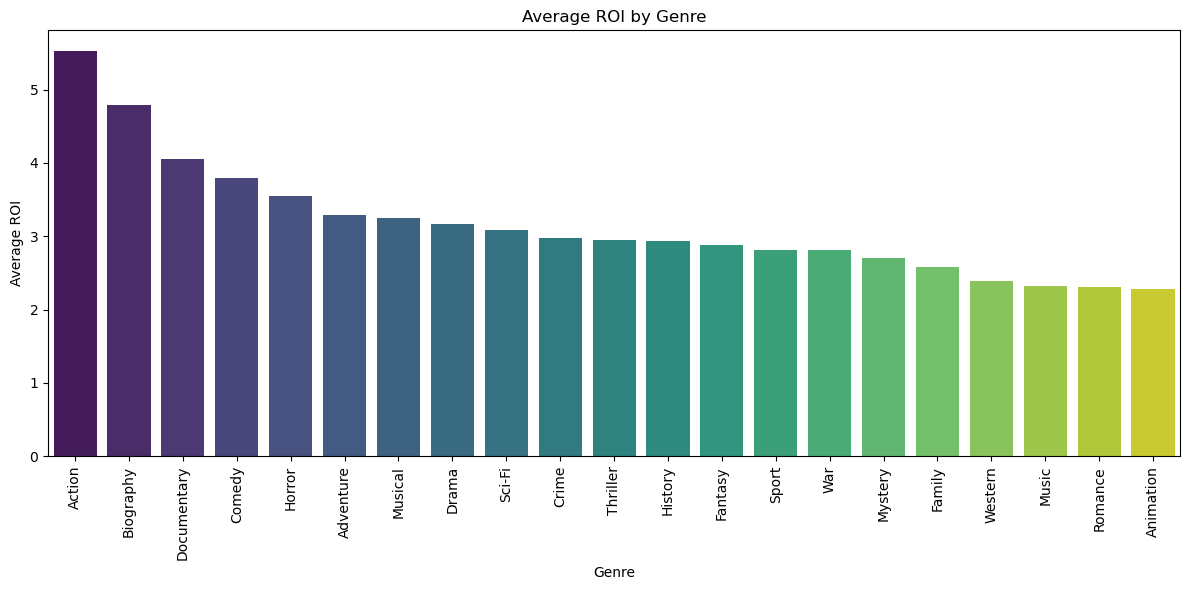

In [6]:
# Here i preprocessed the genres column using the split and stack functions, and then resetting the index
genres_df = relevant_movies_df['genres'].str.split(',', expand=True).stack().reset_index(level=0, drop=True).rename('genre')
merged_df = relevant_movies_df.drop('genres', axis=1).join(genres_df).sort_values(by='ROI', ascending = False)

# Calculate average ROI for each genre
genre_roi_avg = merged_df.groupby('genre')['ROI'].mean().reset_index().sort_values(by='ROI', ascending = False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_roi_avg, x='genre', y='ROI', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.title('Average ROI by Genre')
plt.tight_layout()
plt.show()


# What genres have the best ratings?

In [7]:
#Creating stats for highest rated genres 
genre_stats = merged_df.groupby('genre').agg({'averagerating': 'mean'}).reset_index().sort_values(by='averagerating', ascending=False)

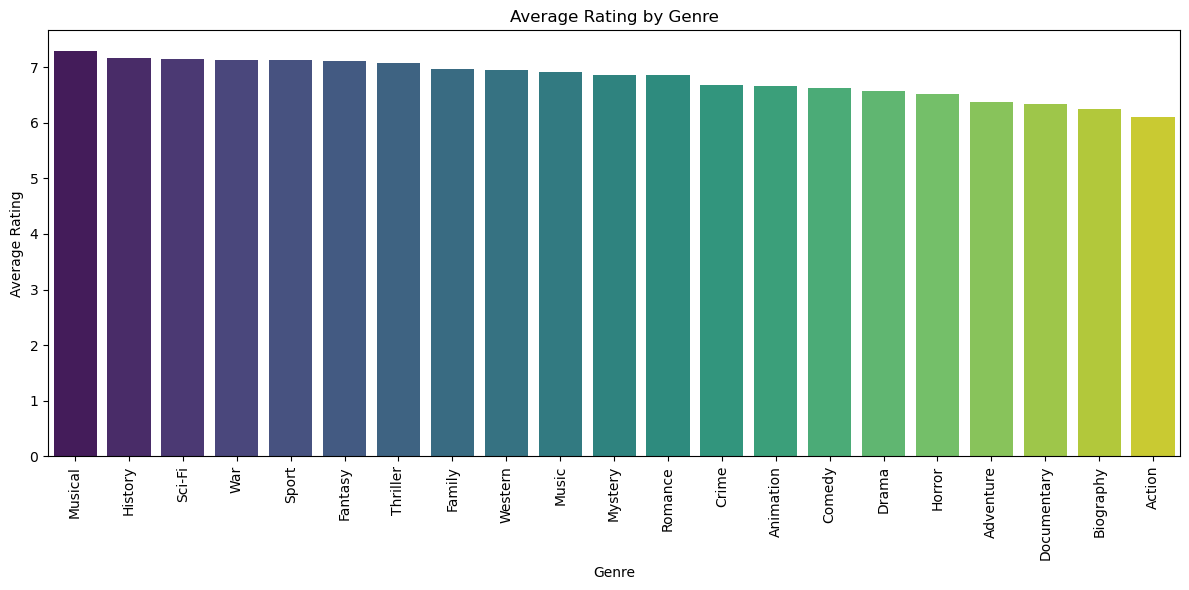

In [8]:
plt.figure(figsize=(12, 6))
sns.barplot(data=genre_stats, x='genre', y='averagerating', palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating by Genre')
plt.tight_layout()
plt.show()


# What musical artists produce the best ratings/ROI

In [20]:
merged_df.columns

Index(['release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'ROI', 'averagerating', 'numvotes',
       'runtime_minutes', 'genre'],
      dtype='object')

In [23]:
people_and_movies_df = pd.read_sql("""
    SELECT p.person_id, primary_name, primary_profession, primary_title, original_title, genres
FROM persons AS p
INNER JOIN known_for AS k ON p.person_id = k.person_id
INNER JOIN movie_basics AS m ON k.movie_id = m.movie_id;

""", conn)
people_and_movies_df.columns

Index(['person_id', 'primary_name', 'primary_profession', 'primary_title',
       'original_title', 'genres'],
      dtype='object')

In [37]:
relevant_people_and_movies = pd.merge(merged_df, people_and_movies_df, how='inner', left_on='movie', right_on='original_title')
relevant_people_and_movies = relevant_people_and_movies.drop_duplicates(subset = 'primary_name').drop(['release_date', 'numvotes',
       'runtime_minutes', 'person_id', 'original_title', 'genre'], axis = 1).sort_values(by = 'ROI', ascending = False)
relevant_people_and_movies

,movie,production_budget,domestic_gross,worldwide_gross,ROI,averagerating,primary_name,primary_profession,primary_title,genres
0,Ghost,22000000,217631306,"$517,600,000",22.527273,2.3,Puja Bedi,"producer,writer,miscellaneous",Ghost,Horror
6,Ghost,22000000,217631306,"$517,600,000",22.527273,2.3,Monisha Hassen,actress,Ghost,"Horror,Thriller"
9,Ghost,22000000,217631306,"$517,600,000",22.527273,2.3,Alex Lipitch,actor,Ghost,"Horror,Thriller"
8,Ghost,22000000,217631306,"$517,600,000",22.527273,2.3,Joanna Shegera,actress,Ghost,"Horror,Thriller"
7,Ghost,22000000,217631306,"$517,600,000",22.527273,2.3,Alex Jones Nash,"art_director,production_designer",Ghost,"Horror,Thriller"
...,...,...,...,...,...,...,...,...,...,...
88306,Free Birds,55000000,55750480,"$110,387,072",1.007038,5.9,Dwight Howard,actor,Free Birds,"Adventure,Animation,Comedy"
88307,Free Birds,55000000,55750480,"$110,387,072",1.007038,5.9,Kaitlyn Maher,"actress,soundtrack",Free Birds,"Adventure,Animation,Comedy"
88308,Free Birds,55000000,55750480,"$110,387,072",1.007038,5.9,Adam Benic,"miscellaneous,actor,writer",Free Birds,"Adventure,Animation,Comedy"
88309,Free Birds,55000000,55750480,"$110,387,072",1.007038,5.9,Jasmine Johnson,"production_manager,miscellaneous,producer",Free Birds,"Adventure,Animation,Comedy"


In [54]:
# Filter by primary_profession containing 'soundtrack'
soundtrack_df = relevant_people_and_movies[relevant_people_and_movies['primary_profession'].str.contains('soundtrack|composer|music_department', na = False)]

# Group by primary_name and count occurrences
top_soundtrack_names = soundtrack_df['primary_name'].value_counts().reset_index()

# Rename columns for clarity
top_soundtrack_names.columns = ['Primary Name', 'Count']

In [55]:
top_soundtrack_names

,Primary Name,Count
0,Alex Lu,1
1,Glen Matisoff,1
2,Depeche Mode,1
3,Steven Severin,1
4,Charlize Theron,1
...,...,...
2809,Elisa,1
2810,Daniel Freiberg,1
2811,Philip White,1
2812,T.I.,1


In [56]:
top_soundtrack_names[top_soundtrack_names['Count'] > 1]

,Primary Name,Count


## Business Questions
What are the top-roi movie genres in the current market, and how have their popularity trends evolved over the past few years?
 - the top roi movie genre is action 


Can we identify any successful trends or patterns in the distribution and marketing strategies of recent blockbuster movies?

What are the most lucrative international markets for Hollywood films, and how can we tailor our content to appeal to these diverse audiences?

Are there any untapped niche genres or storytelling approaches that have shown potential for profitability in the modern movie landscape?

How do critical acclaim and audience reception correlate with box office success, and can we use this information to refine our content development and marketing strategies?

What are the emerging technologies and platforms (e.g., streaming services, virtual reality) that are shaping the future of the film industry, and how can we leverage them to our advantage?

What is the average budget range for successful movies in various genres, and how can we allocate our resources effectively to maximize ROI?

Who are the rising talents, directors, writers, and actors in the industry, and how can we collaborate with them to enhance the appeal of our productions?

What is the competitive landscape like in the movie industry, and what unique selling propositions can our studio develop to stand out and capture market share?